In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle
optimization/btest018.pickle
optimization/btest019.pickle
optimization/btest020.pickle
optimization/btest021.pickle
optimization/btest022.pickle
optimization/btest023.pickle
optimization/btest024.pickle
optimization/btest025.pickle
optimization/btest026.pickle
optimization/btest027.pickle
optimization/btest028.pickle
optimization/btest029.pickle
optimization/btest030.pickle
optimization/btest031.pickle


In [2]:
from backtest import DataParser, MovingWindow
import numpy as np


fsize = 32
tfdict = {"M5":0, "M15":1, "H1":2}
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions:
        f, _ = mw(pos.open_indx)
        x = build_features(f, 
                           pos.dir, 
                           btest.cfg.stops_processor.func.cfg.sl, 
                           btest.cfg.trailing_stop_rate,
                           pos.open_date, 
                           tfdict[btest.cfg.period])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

BTCUSD 314
ETHUSD 354
BTCUSD 219
ETHUSD 295
BTCUSD 180
ETHUSD 241
BTCUSD 151
ETHUSD 216
BTCUSD 392
ETHUSD 433
BTCUSD 287
ETHUSD 337
BTCUSD 254
ETHUSD 304
BTCUSD 213
ETHUSD 268
BTCUSD 427
ETHUSD 472
BTCUSD 347
ETHUSD 377
BTCUSD 292
ETHUSD 346
BTCUSD 272
ETHUSD 312
BTCUSD 453
ETHUSD 515
BTCUSD 389
ETHUSD 418
BTCUSD 338
ETHUSD 387
BTCUSD 314
ETHUSD 354
(10471, 1, 9, 32) (10471,)
20180520 -> 20201230


In [3]:
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split_size)

NameError: name 'test_split_size' is not defined

[001,    33] loss train: 74.0411 | test: 1.4087
[002,    33] loss train: 73.9652 | test: 1.3609
[003,    33] loss train: 73.9971 | test: 1.4373
[004,    33] loss train: 73.9670 | test: 1.4277
[005,    33] loss train: 73.9989 | test: 1.3603
[006,    33] loss train: 73.9163 | test: 1.4859
[007,    33] loss train: 73.9831 | test: 1.4084
[008,    33] loss train: 73.8134 | test: 1.3986
[009,    33] loss train: 73.6923 | test: 1.4860
[010,    33] loss train: 73.7954 | test: 1.4079
000 f1_train: 0.480 f1_test: 0.408
000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 :+1088.7 -> +1284.5 OK
-------------------------------------------------
[          nan           nan 1088.65454102]  ->  [          nan           nan 1284.49560547]
mae_train: 0.48 mae_test: 0.41 ratio: 0.85
av. profit boost: 0.1798927548406875
[001,    33] loss train: 73.9862 | test: 1.3403
[002,    33] loss train: 74.0788 | test: 1.4318
[003,    33] loss train: 73.9426 | test: 1.5225
[004,  

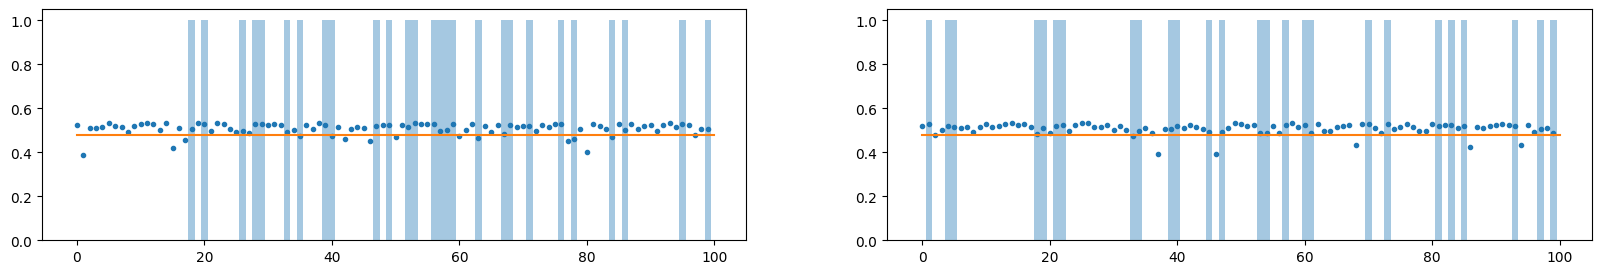

In [110]:
from sklearn.metrics import f1_score
import torch
device = "cuda"

nitrers = 10
test_split_size = 0.2
calc_test = True
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    np.random.seed(1)
    X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split_size)
    model = train(X_train, y_train, X_test, y_test, batch_size=256, device=device, calc_test=calc_test)
    model.eval()
    p_train = model(torch.tensor(X_train).float().to(device)).detach().cpu().numpy().squeeze()[:, 0]
    p_test = model(torch.tensor(X_test).float().to(device)).detach().cpu().numpy().squeeze()[:, 0]
    threshold = np.percentile(p_train, 10)
    # profsum_best, threshold = -999999, None
    # for th in np.arange(0.1, 1, 0.025):
    #     profsum = (profs_train*(p_train>th)).sum()
    #     if profsum > profsum_best:
    #         profsum_best = profsum
    #         threshold = th
    metrics[0, i] = f1_score(p_train>threshold, y_train[:, 0])
    print(f"{i:03} f1_train: {metrics[0, i]:5.3f}", end=" ")
    if test_split_size > 0:
        metrics[1, i] = f1_score(p_test>threshold, y_test[:, 0])
        print(f"f1_test: {metrics[1, i]:5.3f}")
        
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
            gprofits[j, i] = profs_test[ids].sum()
            print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
        
        pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
        gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)
        f1_mean = metrics.mean(axis=1, where=metrics!=0)
        pprofs_mean_tot = np.nanmean(pprofs_mean)
        gprofs_mean_tot = np.nanmean(gprofs_mean)
        print("-------------------------------------------------")
        print(gprofs_mean, " -> ", pprofs_mean)
        print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ratio: {f1_mean[1]/f1_mean[0]:4.2f}")
        print(f"av. profit boost: {(pprofs_mean_tot - gprofs_mean_tot)/abs(gprofs_mean_tot)}")
    else:
        print()
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100, 0], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(1, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(100), y_test[:100, 0], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])
    
model.set_threshold(threshold)
torch.save(model.state_dict(), "model.pth")

In [111]:
pprofits[2].mean(), pprofits[2].std()

(1140.634100341797, 185.3316024865092)

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
# X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

tensor([0.4279, 0.4574, 0.4094,  ..., 0.4670, 0.4131, 0.4660], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [ ]:
list(model.named_parameters())[0]

('threshold',
 Parameter containing:
 tensor([0.3232]))

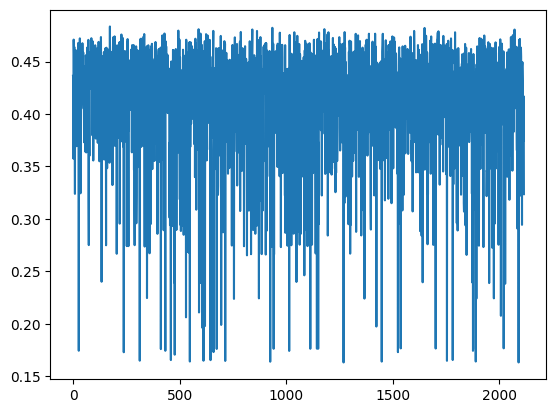

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
threshold

0.22376672327518463

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(776, 1876, 2091, 2091)

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

FileNotFoundError: data/bitfinex/H1

In [ ]:
prediction

array([[0.49287947, 0.50712053]])